In [3]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from toy_datasets import ToyDatasets

In [4]:
class Stage3Algorithm():
  def __init__(self, num_elements, order):
    self.num_elements = num_elements
    self.order = order
    self.A = None

  def objective(self, A, x, y):
    A = A.reshape((self.order, self.order))
    result = np.square(np.linalg.norm(y - A @ x, 2))
    return result.flatten()
  
  def hankelise(self, x):
    """
    A function to take in an input vector of size 1x(n-1) and construct a Hankel matrix
    from it with a specified order (essentially specified number of rows). 
    """

    hankel_matrix = np.zeros((self.order, x.shape[1] - self.order + 1))
    for i in range(self.order):
      hankel_matrix[i, :] = x[0, i:i+x.shape[1]-self.order+1]
    return hankel_matrix
  
  def fit(self, x, y):
    x, y = self.hankelise(x), self.hankelise(y)
    for i in range(len(x)):
      # raise each row to a power except for last row of y
      x[i, :] = np.power(x[i, :], i+1)
      if i != len(x) - 1:
        y[i, :] = np.power(y[i, :], i+2)

    A_initial_guess = np.zeros((self.order, self.order))
    for i in range(self.order-1):
      A_initial_guess[i, i+1] = 1
    # initial guess for A1, A2, ..., Ad are 0
    A = minimize(self.objective, A_initial_guess.flatten(), args=(x, y))
    A = A.x.reshape((self.order, self.order))[-1]
    self.A = A

  def predict(self, x):
    y_predicted = []
    for i in range(self.num_elements - self.order):
      x_subset = x.flatten()[i:i+self.order]
      for j in range(len(x_subset)):
        x_subset[j] = x_subset[j] ** (j+1)
      y_predicted.append(np.dot(x_subset, self.A).flatten()[0])
    return y_predicted
  
  def evaluate(self, y, y_predicted):
    return np.sqrt(1/len(y) * np.sum(np.square(y - y_predicted)))

Without Noise parameters:  [ 1.03579116e+00 -6.99794473e-03  4.48879762e-04]
Without Noise MSE:  9.68584981108205e-05
Gaussian Noise parameters:  [ 0.93618072  0.02523682 -0.00201319]
Gaussian Noise MSE:  0.13629655314396927
Non-Gaussian Noise parameters:  [ 0.9371357   0.02033055 -0.0011643 ]
Non-Gaussian Noise MSE:  0.5003221543682748
Both Noise parameters:  [9.27869634e-01 1.03638916e-02 2.78300939e-04]
Both Noise MSE:  0.5885502978498248


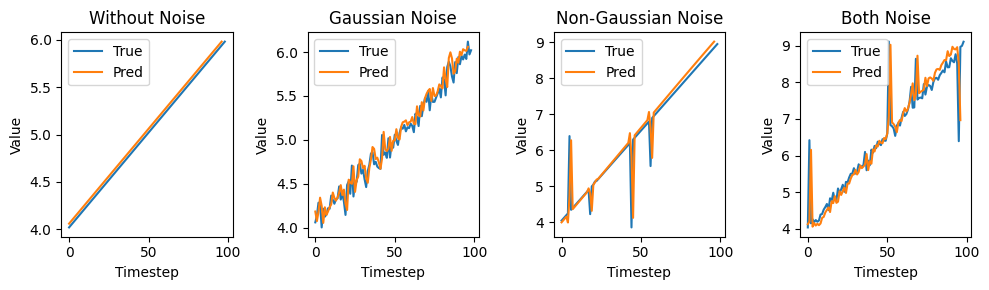

In [7]:
np.random.seed(0)
num_elements, num_features, order = 100, 1, 3
toy_datasets = ToyDatasets(num_elements=num_elements, num_features=num_features)

datasets = [
  ("Without Noise", toy_datasets.linear_trending_without_noise().reshape(-1, 1).T), 
  ("Gaussian Noise", toy_datasets.linear_trending_with_gaussian_noise().reshape(-1, 1).T), 
  ("Non-Gaussian Noise", toy_datasets.linear_trending_with_non_gaussian_noise().reshape(-1, 1).T),
  ("Both Noise", toy_datasets.linear_trending_with_both_noise().reshape(-1, 1).T),
]
fig, ax = plt.subplots(nrows=1, ncols=len(datasets), figsize=(10, 3))
for i, (title, ds) in enumerate(datasets):
  x, y = ds[:, :-1], ds[:, 1:]

  alg = Stage3Algorithm(num_elements=num_elements, order=order)
  alg.fit(x, y)
  ax[i].plot(y.flatten(), label="True")
  
  y_predicted = alg.predict(x)
  ax[i].plot(y_predicted, label="Pred")
  ax[i].set_title(title)
  ax[i].set_xlabel("Timestep")
  ax[i].set_ylabel("Value")
  ax[i].legend()

  print(f"{title} parameters: ", alg.A)

  accuracy = alg.evaluate(y[0, order-1:], y_predicted)
  print(f"{title} MSE: ", accuracy)

plt.tight_layout()
plt.show()

Without Noise parameters:  [ 2.09057824 -0.4397486   0.04349929]
Without Noise MSE:  0.09263429015893294
Gaussian Noise parameters:  [ 1.00394478 -0.01854901  0.00314454]
Gaussian Noise MSE:  0.245967192274283
Non-Gaussian Noise parameters:  [0.93088591 0.0061676  0.00111901]
Non-Gaussian Noise MSE:  0.305960625433189
Both Noise parameters:  [0.87341444 0.01405875 0.00155929]
Both Noise MSE:  0.41005232015618703


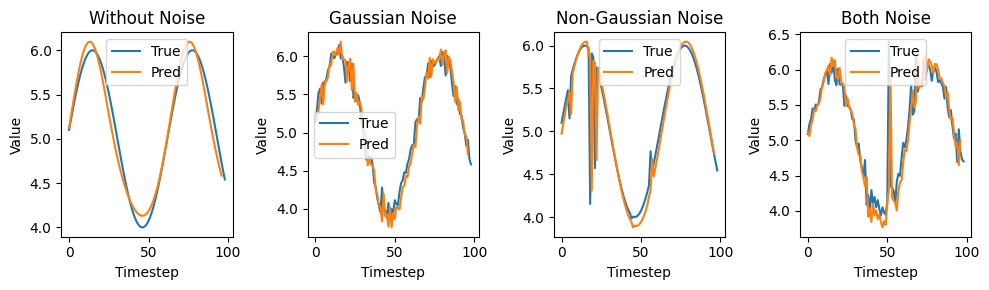

In [8]:
np.random.seed(0)
num_elements, num_features, order = 100, 1, 3
toy_datasets = ToyDatasets(num_elements=num_elements, num_features=num_features)

datasets = [
  ("Without Noise", toy_datasets.periodical_sinusoidal_without_noise().reshape(-1, 1).T), 
  ("Gaussian Noise", toy_datasets.periodical_sinusoidal_with_gaussian_noise().reshape(-1, 1).T), 
  ("Non-Gaussian Noise", toy_datasets.periodical_sinusoidal_with_non_gaussian_noise().reshape(-1, 1).T),
  ("Both Noise", toy_datasets.periodical_sinusoidal_with_both_noise().reshape(-1, 1).T),
]
fig, ax = plt.subplots(nrows=1, ncols=len(datasets), figsize=(10, 3))
for i, (title, ds) in enumerate(datasets):
  x, y = ds[:, :-1], ds[:, 1:]

  alg = Stage3Algorithm(num_elements=num_elements, order=order)
  alg.fit(x, y)
  ax[i].plot(y.flatten(), label="True")
  
  y_predicted = alg.predict(x)
  ax[i].plot(y_predicted, label="Pred")
  ax[i].set_title(title)
  ax[i].set_xlabel("Timestep")
  ax[i].set_ylabel("Value")
  ax[i].legend()

  print(f"{title} parameters: ", alg.A)

  accuracy = alg.evaluate(y[0, order-1:], y_predicted)
  print(f"{title} MSE: ", accuracy)

plt.tight_layout()
plt.show()